In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import *
from firingrate import raster2FR
from plotting_utils import *
from lineplots import plotsd
from hmm_utils import *
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


filelist    = glob.glob('D:/T5_ClosedLoop/*')

sessions_check = np.load('misc_data/sessions_check.npy', allow_pickle = True).item()
min_nblocks    = 3
max_ndays      = 1e99
min_R2         = 0.1

files          = get_Sessions(filelist, min_nblocks)
pairs          = get_SessionPairs(filelist, max_ndays = max_ndays, manually_remove = sessions_check['bad_days'])

files          = np.unique(np.concatenate(pairs))
n_files        = len(files)

## Do some RT and target dwell period characterizations

For a linear decoder with outputs $ u_{t} \in \mathbb{R}^{2} $, and a correct unit-norm point-at-target vector $p_{t}$, we can model:

  $u_{t} = \alpha p_{t} + N(0, \sigma^{2}) $

and define $SNR = \alpha / \sigma $. To model this effectively we chop out:

- RT interval - when participant is not yet using the decoder  (we'll determine this below)
- near target - where outputs can vary quickly with respect to $p_{t}$  (we determine this in *behavior_clicks.ipynb*)

C:\Users\ghwilson\Anaconda3\envs\Speech\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


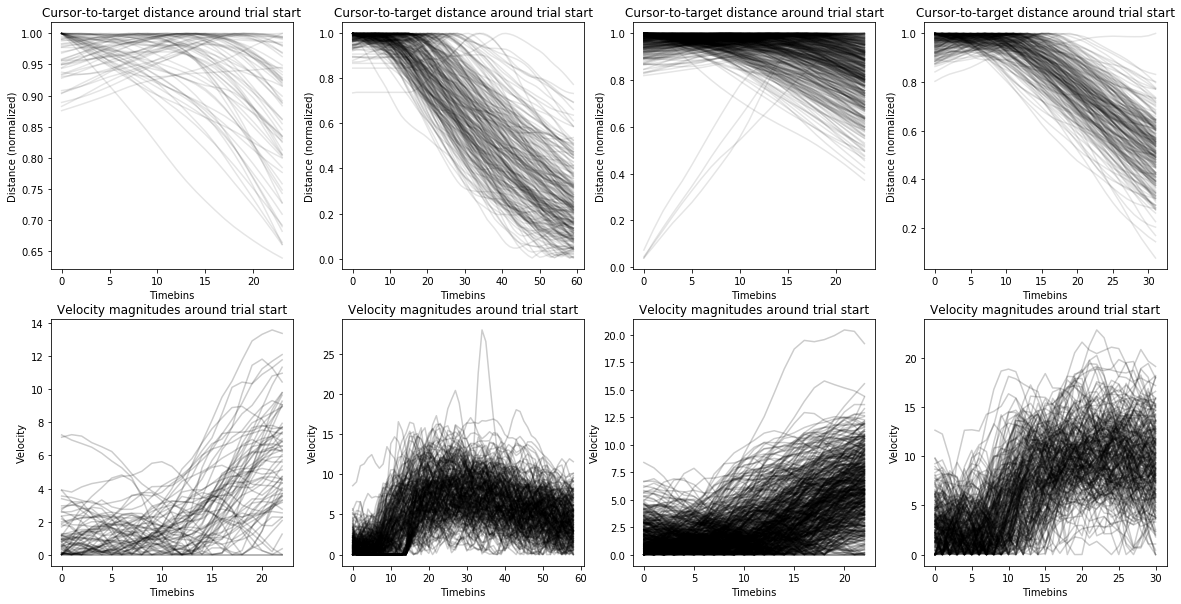

In [4]:
figSize(10, 20)

np.random.seed(42)
diffs           = list()
task            = 'cursor'
train_frac      = 0.5
sigma           = None



for i, f in enumerate(np.random.choice(files, 4, replace = False)):
    dat       = DataStruct(f, alignScreens = True)
    blocks    = [sessions_check[f] if  f in sessions_check.keys() else None][0]
    
    train_x, train_cursorPos, cursorErrs, test_x, test_cursorPos, test_y = prep_HMMData(dat, train_frac = train_frac, task = task, blocks = blocks,  return_flattened = False)
    #cursorErrs = prep_HMMData(dat, train_frac = train_frac, task = task, blocks = blocks, cutStart = cutStart, return_flattened = False)[2]
    #cursorErrs = train_cursorPos
    
    minlen     = np.min([cursorErrs[i].shape[0] for i in range(len(cursorErrs))])
    starts     = np.dstack([cursorErrs[i][:minlen, :] for i in range(len(cursorErrs))])
    dists      = np.linalg.norm(starts, axis = 1)

    plt.subplot(2, 4, i + 1)
    _ = plt.plot(dists / dists.max(axis = 0), color = 'k', alpha = 0.1)
    plt.ylabel('Distance (normalized)')
    plt.xlabel('Timebins')
    plt.title('Cursor-to-target distance around trial start')
    
    minlen     = np.min([train_cursorPos[i].shape[0] for i in range(len(train_cursorPos))])
    velocities = [np.diff(train_cursorPos[i][:minlen, :], axis = 0) for i in range(len(train_cursorPos))]
    magnitudes = [np.linalg.norm(velocities[i], axis = 1) for i in range(len(train_cursorPos))]
    
    plt.subplot(2, 4, i + 5)
    for trl in magnitudes:
        plt.plot(trl - trl.min(), color = 'k', alpha = 0.2)
        
    plt.ylabel('Velocity')
    plt.xlabel('Timebins')
    plt.title('Velocity magnitudes around trial start')

    

Let's visualize the parts of a trial that we're using for the following SNR timepoint restrictions:

- thresh    = 50  *only calculate SNR using points far from target*
- cutStart  = 15  *exclude first 10 timesteps (300 ms to account for RT)*


Text(0, 0.5, 'y pos')

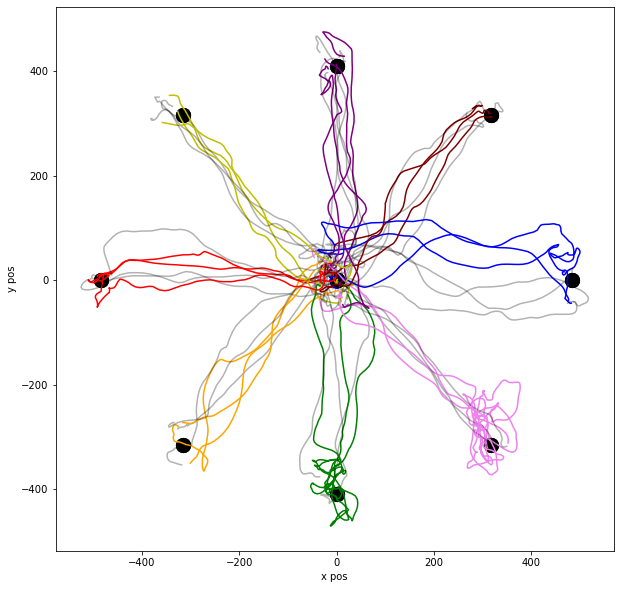

In [5]:
from matplotlib import colors 
figSize(10, 10)

day = 10


dat = DataStruct(files[day])

n_trials         = 50

cmap             = colors.ListedColormap(['r', 'orange', 'y', 'g', 'k', 'purple', 'violet', 'maroon', 'b'])
unique, targetID = np.unique(np.vstack([dat.targetPos[i][0, :] for i in range(n_trials)]), return_inverse= True, axis = 0)

for i in range(n_trials):
    color       = cmap(targetID[i])
    plt.scatter(dat.targetPos[i][0, 0], dat.targetPos[i][0, 1], color = 'k', s = 200)
    alpha       = [0.3 if targetID[i]== 4 else 1][0]
    plt.plot(dat.cursorPos[i][:, 0], dat.cursorPos[i][:, 1], color = color, alpha = alpha)

plt.xlabel('x pos')
plt.ylabel('y pos')

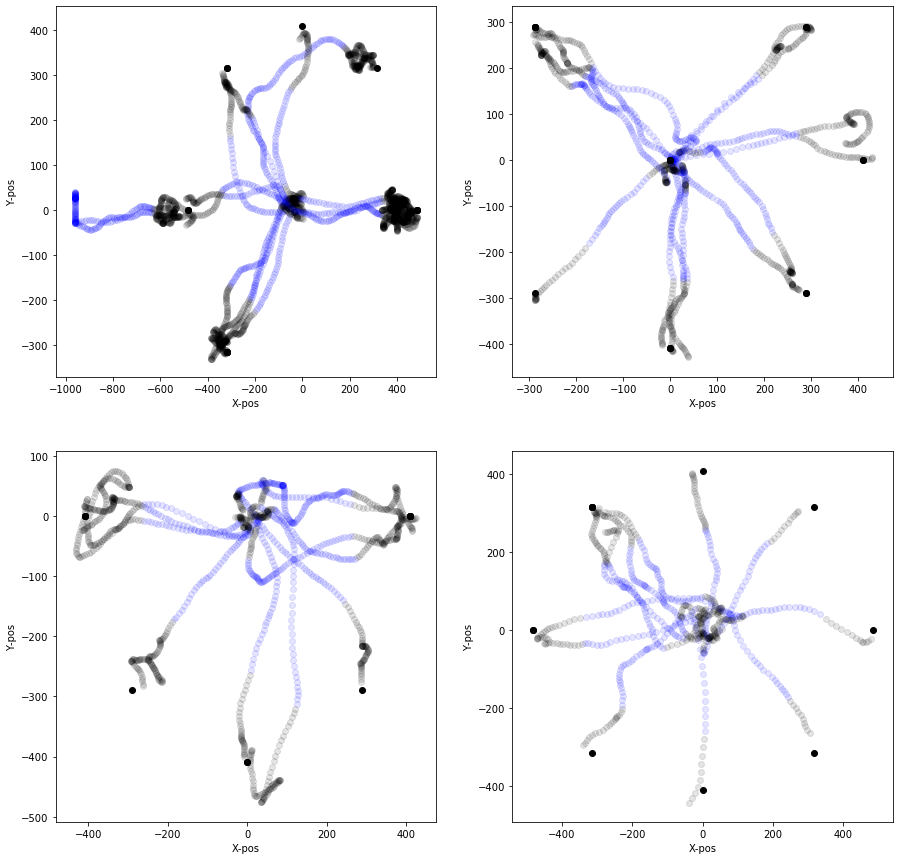

In [6]:
figSize(15, 15)

# general settings:
np.random.seed(42)
diffs           = list()
task            = 'cursor'
train_frac      = 0.5
sigma           = None
n_plot          = 20   # number of reach trajectories to plot 

# SNR calculation settings:
thresh          = 150  # only calculate SNR using points far from target
cutStart        = 15   # exclude first 10 timesteps (300 ms to account for RT)

for i, f in enumerate(np.random.choice(files, 4, replace = False)):
    dat       = DataStruct(f, alignScreens = True)
    blocks    = [sessions_check[f] if  f in sessions_check.keys() else None][0]
    
    train_x, train_cursorPos, train_y, test_x, test_cursorPos, test_y = prep_HMMData(dat, train_frac = train_frac, task = task, blocks = blocks, cutStart = 0, return_flattened = False)
    n_trls    = len(train_y)
    
    plt.subplot(2, 2, i + 1)
    plt.xlabel('X-pos')
    plt.ylabel('Y-pos')
    for j in np.random.choice(n_trls, n_plot, replace = False):
        targ      = train_y[j][1, :] + train_cursorPos[j][1, :]
        if (targ != [0, 0]).any():
            dists     = np.linalg.norm(train_y[j], axis = 1)
            too_close = np.where(dists < thresh)[0]
            unused    = np.concatenate([np.arange(cutStart), too_close])
            used      = np.setdiff1d(np.arange(len(dists)),unused)

            _ = plt.scatter(train_cursorPos[j][used, 0], train_cursorPos[j][used, 1], color = 'b', alpha = 0.1)
            _ = plt.scatter(train_cursorPos[j][unused, 0], train_cursorPos[j][unused, 1], color = 'k', alpha = 0.1)
            plt.scatter(targ[0], targ[1], color = 'k')


In [ ]:
from hmm_utils import prep_HMMData

# general settings:
np.random.seed(42)
diffs           = list()
task            = 'cursor'
train_frac      = 0.5
sigma           = None

# SNR calculation settings:
thresh          = 300  # only calculate SNR using points far from target
cutStart        = 7   # exclude first 10 timesteps (300 ms to account for RT)

SNRs   = list()
scores = list()
for i, session in enumerate(files):  
    dat       = DataStruct(session, alignScreens = True)
    blocks    = [sessions_check[session] if  session in sessions_check.keys() else None][0]

     # obtain features and cursorError targets:
    train_x, train_cursorPos, train_y, test_x, test_cursorPos, test_y = prep_HMMData(dat, train_frac = train_frac, task = task, blocks = blocks, cutStart = cutStart, return_flattened = True)
   
    train_targetPos, test_targetPos = train_cursorPos + train_y, test_cursorPos + test_y
    score, decoder                  = traintest_DecoderSupervised([train_x], [test_x], [train_y], [test_y], decoder = None, meanRecal = False)
    
    p_t  = (test_targetPos - test_cursorPos)
    p_t /= np.linalg.norm(p_t, axis = 1)[:, np.newaxis]  # unit vector pointing at target
    u_t  = decoder.predict(test_x)                       # decoder outputs 

    dists  = np.linalg.norm(test_y, axis = 1)

    ut_thresh = u_t[dists > thresh, :].flatten()[:, np.newaxis]
    pt_thresh =  p_t[dists > thresh, :].flatten()[:, np.newaxis]

    mult  = np.linalg.lstsq(pt_thresh, ut_thresh, rcond = None)[0][0][0]
    res   = ut_thresh - (pt_thresh * mult)
    
    SNRs.append(mult / np.std(res))
    scores.append(score[0])

SNRs = np.asarray(SNRs)

Median SNR:  1.5722475864526106


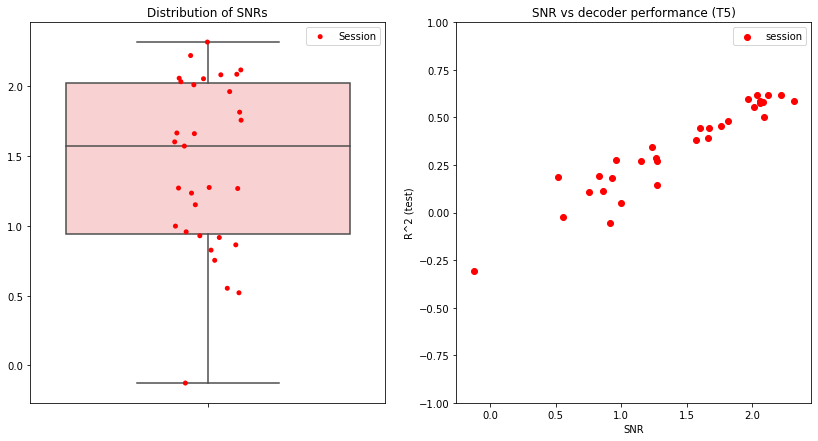

In [284]:
import seaborn as sns
figSize(7, 14)


plt.subplot(1, 2, 1)
plt.title('Distribution of SNRs')
sns.boxplot(SNRs, orient = 'v', color = 'r')
ax = plt.gca()
modifyBoxPlotAlpha(ax, 0.2)
sns.stripplot(SNRs, orient = 'v', color = 'r', label = 'Session', jitter = 0.1)
plt.legend()
#plt.violinplot(SNRs)

plt.subplot(1,2,2)
plt.scatter(SNRs, scores, label = 'session', color = 'r')
plt.ylim(-1, 1)
plt.legend()
plt.xlabel('SNR')
plt.ylabel('R^2 (test)')
plt.title('SNR vs decoder performance (T5)')
print('Median SNR: ', np.median(SNRs))

